<a href="https://colab.research.google.com/github/Ayonator77/Alpha-Pilot/blob/master/AlphaPilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
from tensorflow.keras import Model, layers, callbacks, regularizers
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_set = np.load("/content/drive/My Drive/AP_dataset_float1RGB.npz")

In [4]:
x_train, y_train = data_set['x_train'], data_set['y_train']
x_val, y_val = data_set['x_val'], data_set['y_val']
x_test, y_test = data_set['x_test'], data_set['y_test']
call_list=[callbacks.EarlyStopping(monitor='mae', patience=2), callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Model saves/resnet_v1.h5', monitor='val_loss', save_file_only=True),
           callbacks.TensorBoard(log_dir="/content/drive/My Drive/Colab Notebooks"), 
           callbacks.ReduceLROnPlateau(monitor='loss', min_delta=0.05, cooldown=2, factor=0.005, patience=1, verbose=1)]

In [5]:
class ResNetBlock(layers.Layer):
  def __init__(self, num_filters, filter_size):
    super(ResNetBlock, self).__init__()
    self.conv1 = layers.Conv2D(num_filters, (1, 1), padding='same')
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')
    self.bn2 = layers.BatchNormalization()

    self.conv3 = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')
    self.bn3 = layers.BatchNormalization()
  
  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    x += input_tensor
    return tf.nn.relu(x)

In [6]:
class TestModel(Model):
    def __init__(self):
        super(TestModel, self).__init__()
        self.conv1 = layers.SeparableConv2D(64, (1, 1), padding='same', input_shape=(216, 324, 3))
        self.conv2 = layers.SeparableConv2D(64, (1, 1), padding='same', activation='relu')
        self.conv3 = layers.SeparableConv2D(64, (1, 1), padding='same', activation='relu')
        self.res1 = ResNetBlock(64, 1)
        self.drop0 = layers.Dropout(0.5)
        
        self.batch1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPool2D(4, 4)
        

        self.conv4 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')
        self.conv5 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')        
        self.conv6 = layers.SeparableConv2D(128, (1, 1), padding='same' ,activation='relu')
        self.res2 = ResNetBlock(128, 1)
        self.drop1 = layers.Dropout(0.125)

        self.batch2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPool2D(4, 4)

        self.conv7 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')
        self.conv8 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')        
        self.conv9 = layers.SeparableConv2D(128, (1, 1), padding='same' ,activation='relu')
        self.res3 = ResNetBlock(128, 1)
        self.drop2 = layers.Dropout(0.125)


        self.conv10 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')
        self.conv11 = layers.SeparableConv2D(128, (1, 1), padding='same', activation='relu')        
        self.conv12 = layers.SeparableConv2D(128, (1, 1), padding='same' ,activation='relu')
        self.res4 = ResNetBlock(128, 3)
        self.drop3 = layers.Dropout(0.125)
        

        self.conv13 = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')
        self.conv14 = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')        
        self.conv15 = layers.SeparableConv2D(128, (3, 3), padding='same' ,activation='relu')
        self.res5 = ResNetBlock(128, 3)
        self.drop4 = layers.Dropout(0.125)
  
        
        self.flat = layers.Flatten()
        self.dense1 = layers.Dense(1024, activation='relu')
        self.dense2 = layers.Dense(1024,activation='relu')
        self.out = layers.Dense(8)
      


    def call(self, x):
        x = tf.reshape(x, [-1, 216, 324, 3])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res1(x)
        s = self.drop0(x)
        
        x = self.batch1(x)
        x = self.pool1(x)
        
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.res2(x)
        x = self.drop1(x)
        
        x = self.batch2(x)
        x = self.pool2(x)
        
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.res3(x)
        x = self.drop2(x)
        
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.res4(x)
        x = self.drop3(x)

        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.res5(x)
        x = self.drop4(x)
        
        x = self.flat(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x
    

In [7]:
model = TestModel()
model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(), metrics=['mae'])
acc = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val), callbacks=call_list, shuffle=True)
model.evaluate(x_test, y_test, batch_size=32)

Epoch 1/30
  1/173 [..............................] - ETA: 0s - loss: 19602.6641 - mae: 133.9993WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
173/173 [==============================] - 125s 721ms/step - loss: 370.9011 - mae: 10.3680 - val_loss: 19667.0195 - val_mae: 134.3083
Epoch 2/30
173/173 [==============================] - 119s 686ms/step - loss: 95.6604 - mae: 6.4934 - val_loss: 15145.5664 - val_mae: 117.7199
Epoch 3/30
173/173 [==============================] - 119s 686ms/step - loss: 71.9320 - mae: 5.3257 - val_loss: 5357.1138 - val_mae: 67.0243
Epoch 4/30
173/173 [==============================] - 119s 687ms/step - loss: 66.0317 - mae: 5.1821 - val_loss: 7898.9502 - val_mae: 85.1179
Epoch 5/30
173/173 [==============================] - ETA: 0s - los

[61.06574630737305, 3.977813243865967]

In [ ]:
"""Saves model with """
def model_test_prediction():
  values = []
  for i in range(len(x_test)):
    y = model(x_test[i])
    values.append(y[0].numpy().tolist())
  
  model_pred = dict(list(enumerate(values)))
  return model_pred

In [ ]:
model_pred = model_test_prediction()
model_pred

In [ ]:
import json
model_pred = model_test_prediction()
with open('/content/drive/My Drive/Colab Notebooks/Model saves/model_prediction.json', 'w') as file:
  json.dump(model_pred, file)



In [ ]:
def correct_ylabels():
  val_true = []
  for i in range(len(y_test)):
    val_true.append(y_test[i].tolist())
  return dict(list(enumerate(val_true)))

data = correct_ylabels()

with open('/content/drive/My Drive/Colab Notebooks/Model saves/true_labels.json', 'w') as file:
  json.dump(data, file)


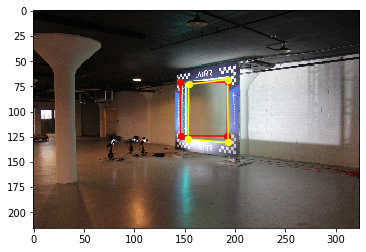

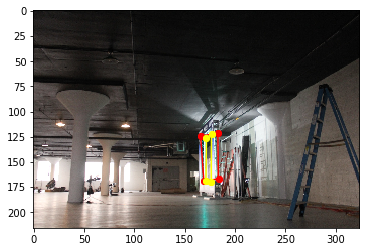

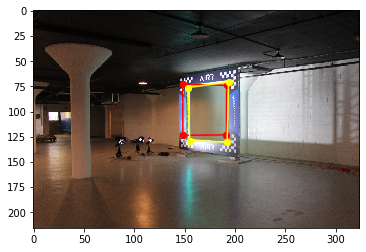

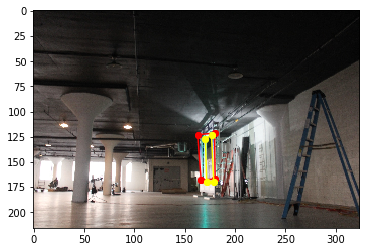

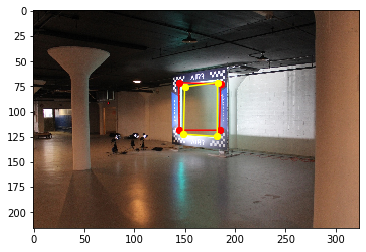

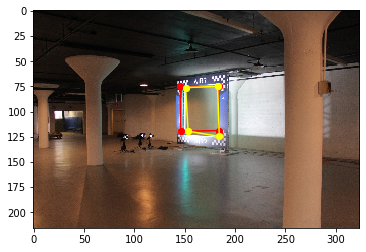

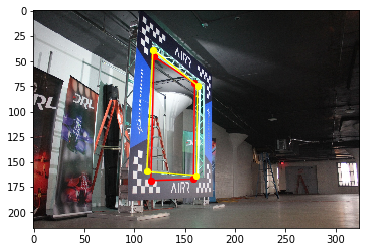

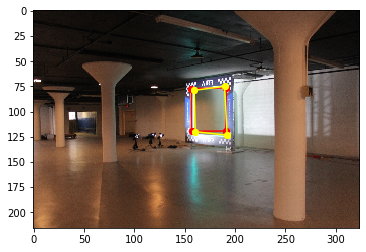

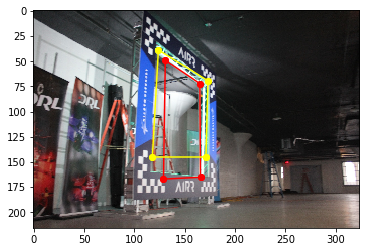

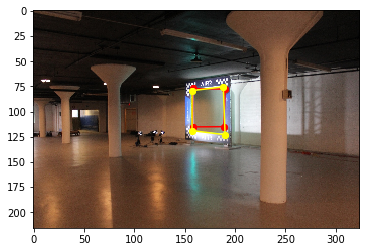

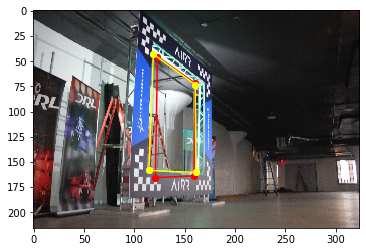

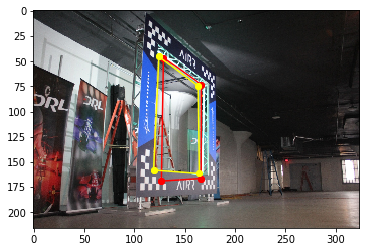

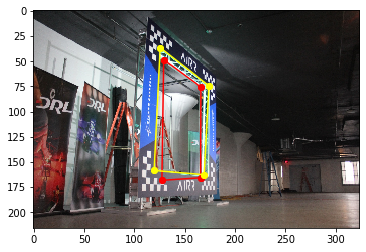

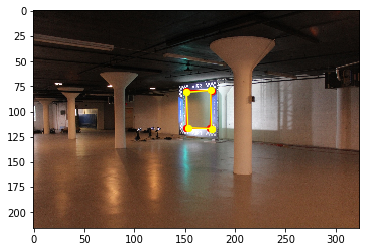

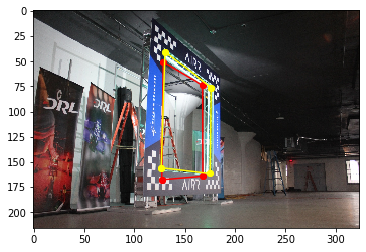

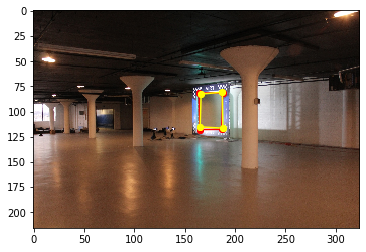

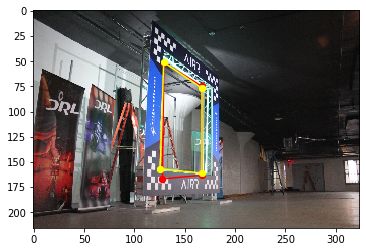

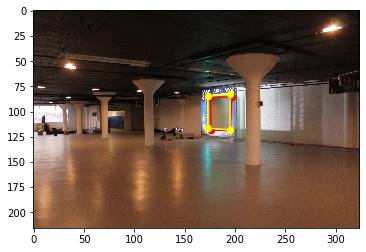

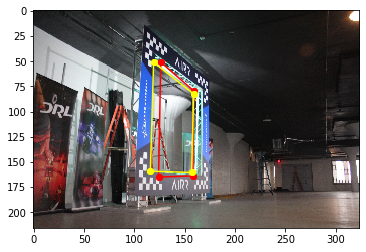

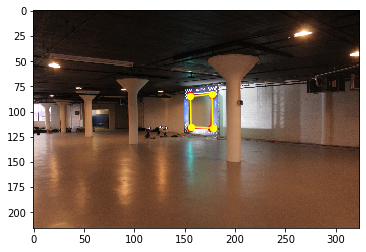

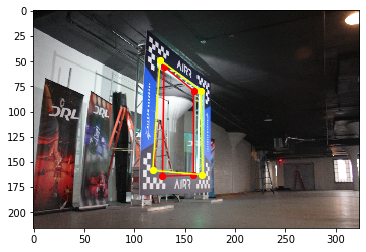

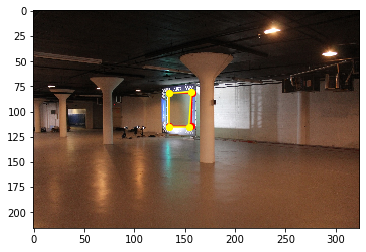

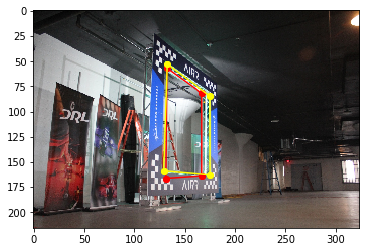

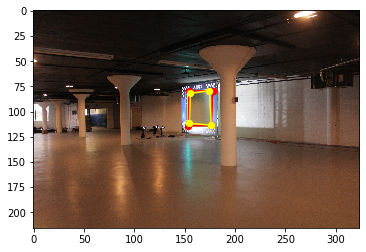

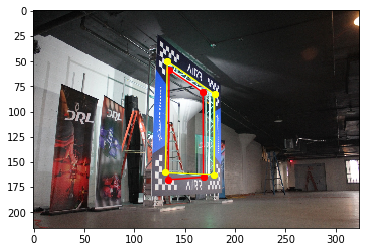

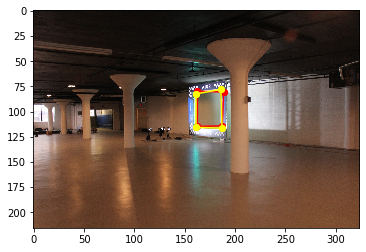

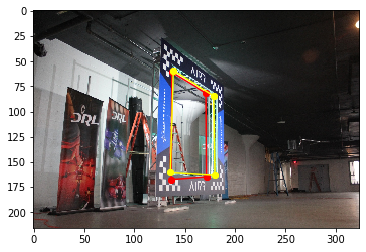

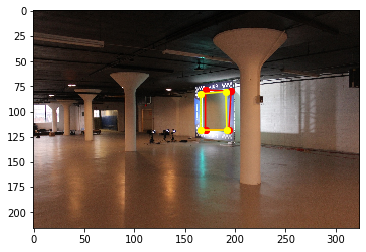

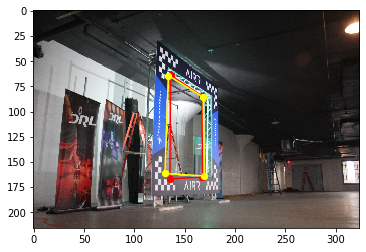

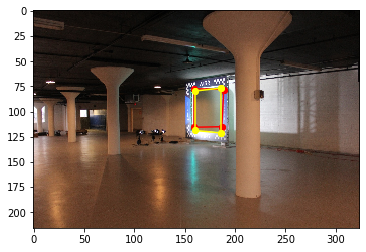

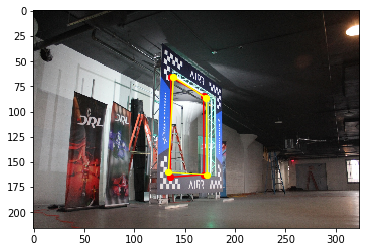

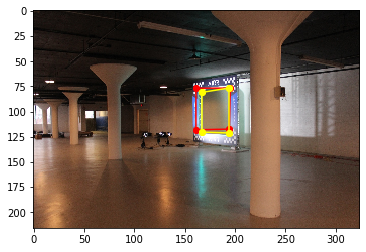

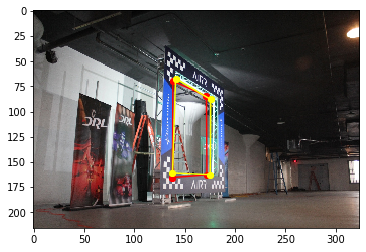

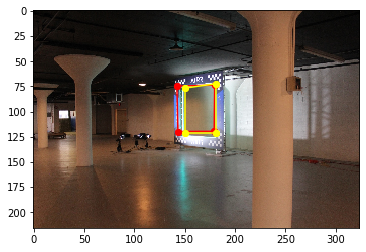

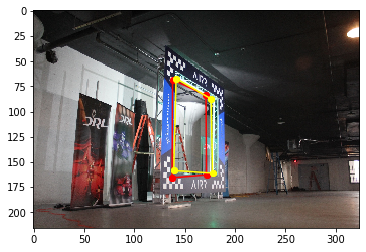

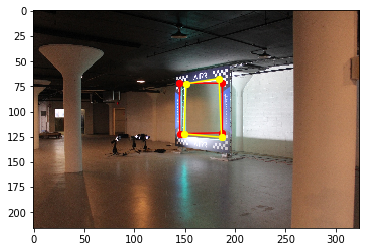

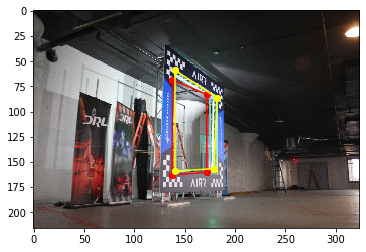

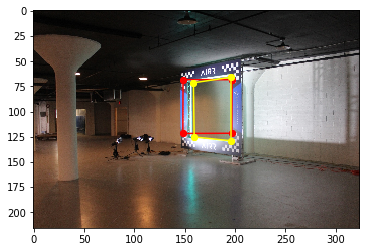

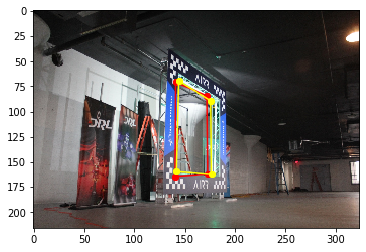

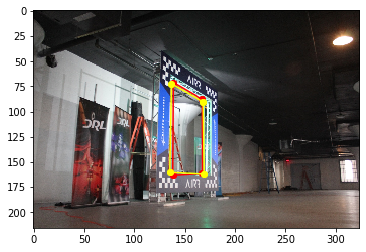

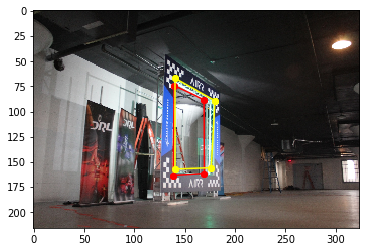

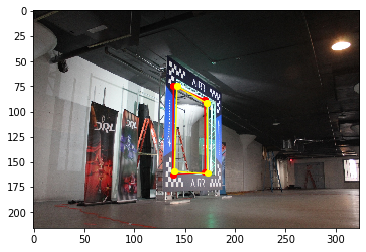

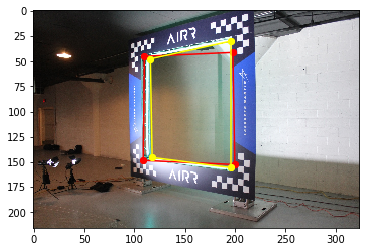

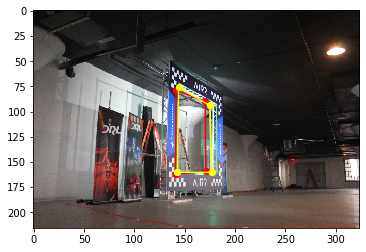

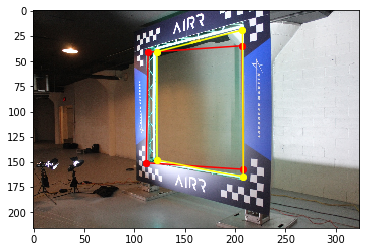

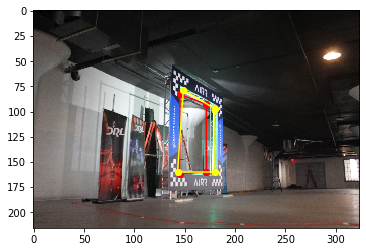

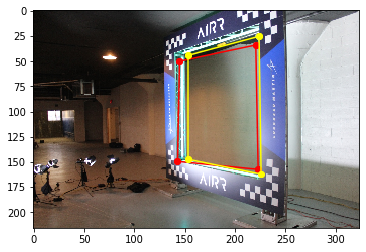

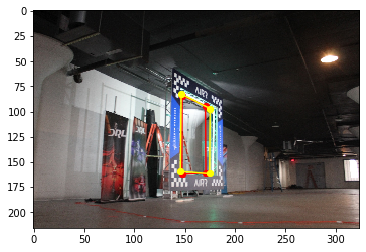

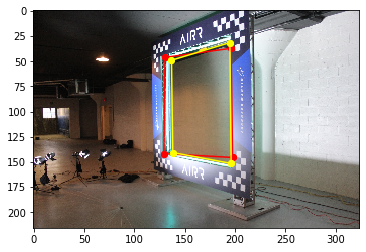

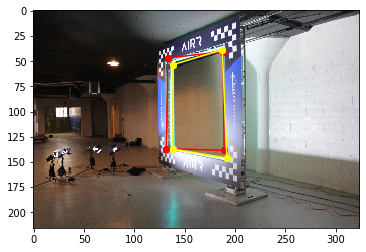

In [ ]:
def check(num_images):
  for i in range(num_images):
    y = model(x_test[i])
    point_1 = y[0][0:2]
    point_2 = y[0][2:4]
    point_3 = y[0][4:6]
    point_4 = y[0][6:8]
            
    # plt.plot([x1, x2], [y1, y2])
    plt.plot([point_1[0], point_2[0]],[point_1[1], point_2[1]],[point_3[0], 
              point_4[0]], [point_3[1], point_4[1]],[point_1[0], point_4[0]], [point_1[1],
                            point_4[1]],[point_2[0], point_3[0]], [point_2[1], point_3[1]], marker =  'o', color='red')
    
    y_hat = y_test[i]
    point_1h = y_hat[0:2]
    point_2h = y_hat[2:4]
    point_3h = y_hat[4:6]
    point_4h = y_hat[6:8]

    plt.plot([point_1h[0], point_2h[0]],[point_1h[1], point_2h[1]],[point_3h[0], 
              point_4h[0]], [point_3h[1], point_4h[1]],[point_1h[0], point_4h[0]], [point_1h[1],
                            point_4h[1]],[point_2h[0], point_3h[0]], [point_2h[1], point_3h[1]], marker =  'o', color='yellow')
            

    plt.imshow(x_test[i])
    plt.show()

check(50)

In [ ]:
!python score_detections.py -g '/content/drive/My Drive/Colab Notebooks/Model saves/true_labels.json' -p '/content/drive/My Drive/Colab Notebooks/Model saves/model_prediction.json'